In [1]:
from random import seed
from random import randrange
from random import random
import pandas as pd
from math import exp

In [2]:
# # Load a CSV file
# def load_csv(filename):
# 	dataset = list()
# 	with open(filename, 'r') as file:
# 		csv_reader = reader(file)
# 		for row in csv_reader:
# 			if not row:
# 				continue
# 			dataset.append(row)
# 	return dataset

In [3]:
# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())

In [4]:
# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup

In [5]:
# Find the min and max values for each column
def dataset_minmax(dataset):
	minmax = list()
	stats = [[min(column), max(column)] for column in zip(*dataset)]
	return stats

In [6]:
# Rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
	for row in dataset:
		for i in range(len(row)-1):
			row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

In [7]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

In [8]:
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

In [9]:
from sklearn import metrics
import matplotlib.pyplot as plt

# Evaluate an algorithm using a cross validation split


def evaluate_algorithm(dataset, algorithm, n_folds, *args):
  folds = cross_validation_split(dataset, n_folds)
  scores = list()
  for fold in folds:
    train_set = list(folds)
    train_set.remove(fold)
    train_set = sum(train_set, [])
    test_set = list()
    for row in fold:
      row_copy = list(row)
      test_set.append(row_copy)
      row_copy[-1] = None
    predicted = algorithm(train_set, test_set, *args)
    actual = [row[-1] for row in fold]
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=[0, 1, 2])
    cm_display.title = 'Confusion Matrix - Fold {}' .format(folds.index(fold))
    cm_display.plot()
    accuracy = accuracy_metric(actual, predicted)
    scores.append(accuracy)
  return scores

In [10]:
# Calculate neuron activation for an input
def activate(weights, inputs):
	activation = weights[-1]
	for i in range(len(weights)-1):
		activation += weights[i] * inputs[i]
	return activation

In [11]:
# Transfer neuron activation
def transfer(activation):
	return 1.0 / (1.0 + exp(-activation))

In [12]:
# Forward propagate input to a network output
def forward_propagate(network, row):
	inputs = row
	for layer in network:
		new_inputs = []
		for neuron in layer:
			activation = activate(neuron['weights'], inputs)
			neuron['output'] = transfer(activation)
			new_inputs.append(neuron['output'])
		inputs = new_inputs
	return inputs


In [13]:

# Calculate the derivative of an neuron output
def transfer_derivative(output):
	return output * (1.0 - output)

In [14]:
# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
	for i in reversed(range(len(network))):
		layer = network[i]
		errors = list()
		if i != len(network)-1:
			for j in range(len(layer)):
				error = 0.0
				for neuron in network[i + 1]:
					error += (neuron['weights'][j] * neuron['delta'])
				errors.append(error)
		else:
			for j in range(len(layer)):
				neuron = layer[j]
				errors.append(neuron['output'] - expected[j])
		for j in range(len(layer)):
			neuron = layer[j]
			neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

In [15]:
# Update network weights with error
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			inputs = [neuron['output'] for neuron in network[i - 1]]
		for neuron in network[i]:
			for j in range(len(inputs)):
				neuron['weights'][j] -= l_rate * neuron['delta'] * inputs[j]
			neuron['weights'][-1] -= l_rate * neuron['delta']

In [16]:
# Train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
	for epoch in range(n_epoch):
		for row in train:
			outputs = forward_propagate(network, row)
			expected = [0 for i in range(n_outputs)]
			expected[row[-1]] = 1
			backward_propagate_error(network, expected)
			update_weights(network, row, l_rate)

In [17]:
# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs):
	network = list()
	hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
	network.append(hidden_layer)
	output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
	network.append(output_layer)
	return network

In [18]:
# Make a prediction with a network
def predict(network, row):
	outputs = forward_propagate(network, row)
	return outputs.index(max(outputs))

In [19]:
# Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, l_rate, n_epoch, n_hidden):
	n_inputs = len(train[0]) - 1
	n_outputs = len(set([row[-1] for row in train]))
	network = initialize_network(n_inputs, n_hidden, n_outputs)
	train_network(network, train, l_rate, n_epoch, n_outputs)
	predictions = list()
	for row in test:
		prediction = predict(network, row)
		predictions.append(prediction)
	return(predictions)

In [20]:
# Test Backprop on Seeds dataset
seed(1)

In [21]:
# load and prepare data
#filename = 'dataset/seeds.csv'
filename = 'dataset/iris.csv'
dataset = pd.read_csv(filename, header=0)
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [22]:
# to list
if isinstance(dataset, pd.DataFrame):
  dataset = dataset.values.tolist()
print(f' ==> [Line 2]: \033[38;2;169;21;206m[dataset]\033[0m({type(dataset).__name__}) = \033[38;2;160;41;145m{dataset}\033[0m')

 ==> [Line 2]: [dataset](list) = [[5.1, 3.5, 1.4, 0.2, 'setosa'], [4.9, 3.0, 1.4, 0.2, 'setosa'], [4.7, 3.2, 1.3, 0.2, 'setosa'], [4.6, 3.1, 1.5, 0.2, 'setosa'], [5.0, 3.6, 1.4, 0.2, 'setosa'], [5.4, 3.9, 1.7, 0.4, 'setosa'], [4.6, 3.4, 1.4, 0.3, 'setosa'], [5.0, 3.4, 1.5, 0.2, 'setosa'], [4.4, 2.9, 1.4, 0.2, 'setosa'], [4.9, 3.1, 1.5, 0.1, 'setosa'], [5.4, 3.7, 1.5, 0.2, 'setosa'], [4.8, 3.4, 1.6, 0.2, 'setosa'], [4.8, 3.0, 1.4, 0.1, 'setosa'], [4.3, 3.0, 1.1, 0.1, 'setosa'], [5.8, 4.0, 1.2, 0.2, 'setosa'], [5.7, 4.4, 1.5, 0.4, 'setosa'], [5.4, 3.9, 1.3, 0.4, 'setosa'], [5.1, 3.5, 1.4, 0.3, 'setosa'], [5.7, 3.8, 1.7, 0.3, 'setosa'], [5.1, 3.8, 1.5, 0.3, 'setosa'], [5.4, 3.4, 1.7, 0.2, 'setosa'], [5.1, 3.7, 1.5, 0.4, 'setosa'], [4.6, 3.6, 1.0, 0.2, 'setosa'], [5.1, 3.3, 1.7, 0.5, 'setosa'], [4.8, 3.4, 1.9, 0.2, 'setosa'], [5.0, 3.0, 1.6, 0.2, 'setosa'], [5.0, 3.4, 1.6, 0.4, 'setosa'], [5.2, 3.5, 1.5, 0.2, 'setosa'], [5.2, 3.4, 1.4, 0.2, 'setosa'], [4.7, 3.2, 1.6, 0.2, 'setosa'], [4.8, 

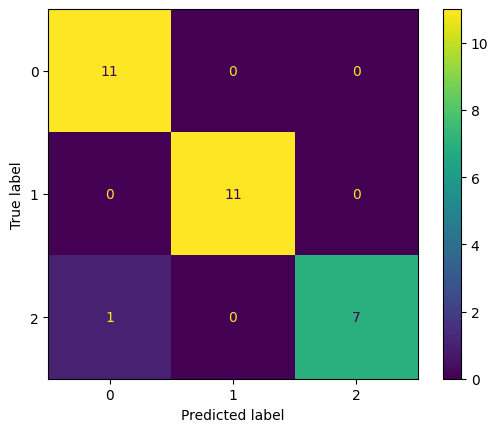

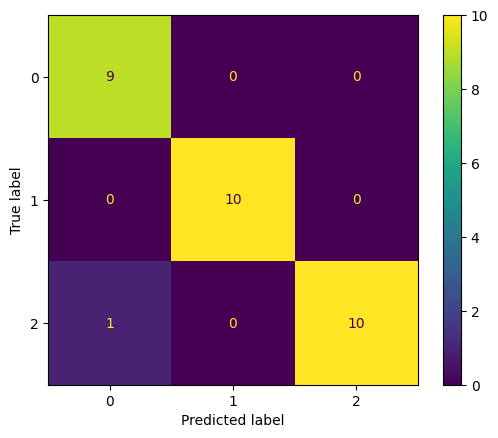

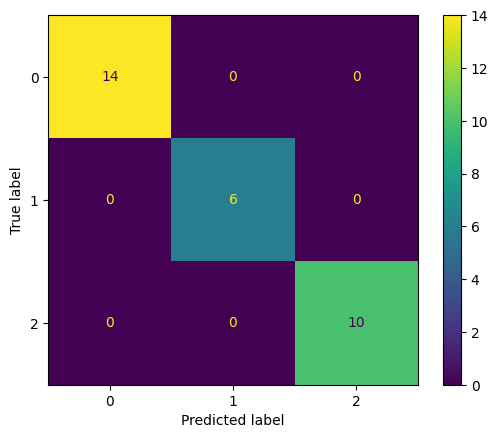

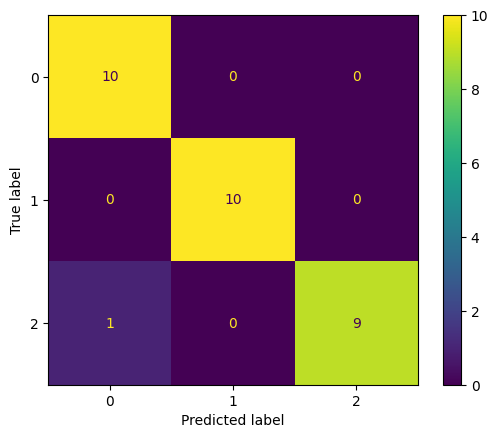

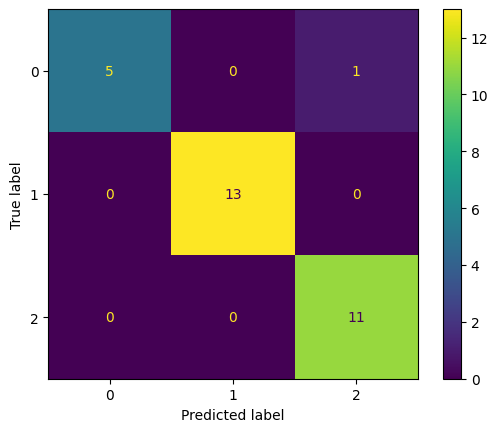

In [ ]:
# for i in range(len(dataset[0])-1):
# 	str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)
# normalize input variables
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)
# evaluate algorithm
n_folds = 5
l_rate = 0.1 # ลด lr
n_epoch = 500
n_hidden = 10
scores = evaluate_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden)

In [24]:
# ลด lr
mean_accuracy = sum(scores) / len(scores)
print(f' ==> [Line 13]: \033[38;2;168;222;231m[scores]\033[0m({type(scores).__name__}) = \033[38;2;2;222;41m{scores}\033[0m')
print(f' ==> [Line 15]: \033[38;2;185;50;113m[mean_accuracy]\033[0m({type(mean_accuracy).__name__}) = \033[38;2;190;227;4m{mean_accuracy}\033[0m')

 ==> [Line 13]: [scores](list) = [96.66666666666667, 96.66666666666667, 100.0, 96.66666666666667, 96.66666666666667]
 ==> [Line 15]: [mean_accuracy](float) = 97.33333333333334


 ==> [Line 13]: [scores](list) = [90.0, 96.66666666666667, 100.0, 100.0, 96.66666666666667]
 ==> [Line 15]: [mean_accuracy](float) = 96.66666666666667


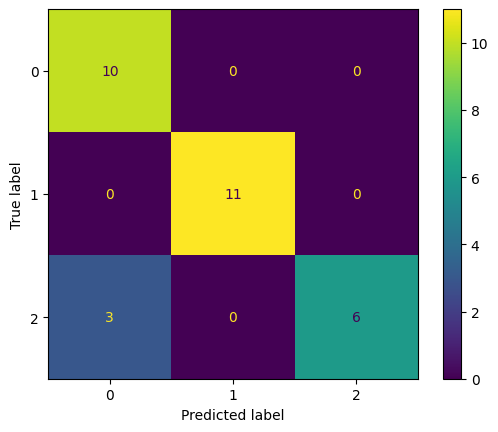

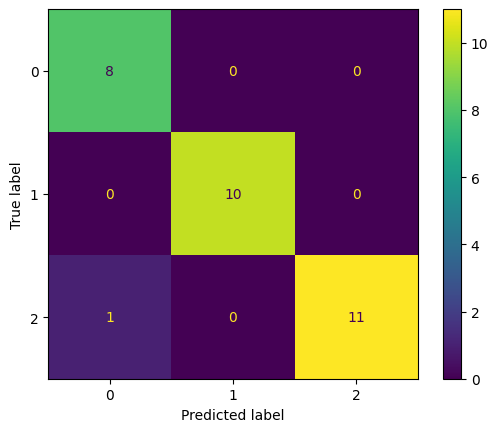

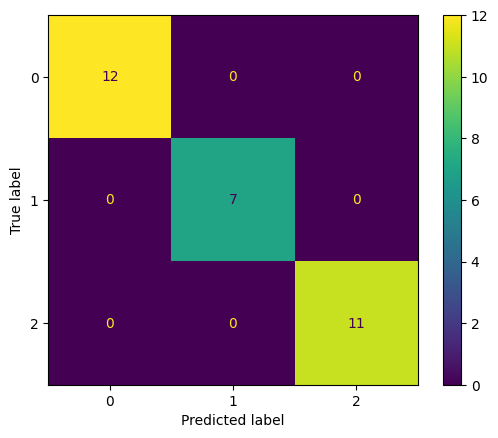

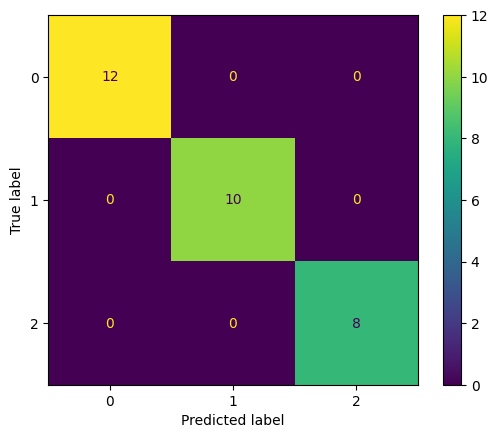

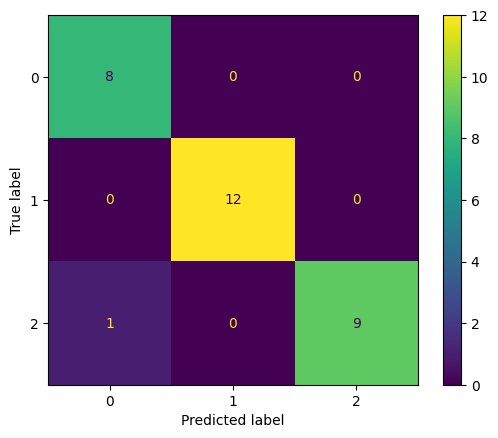

In [25]:
# for i in range(len(dataset[0])-1):
# 	str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)
# normalize input variables
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)
# evaluate algorithm
n_folds = 5
l_rate = 0.5
n_epoch = 500
n_hidden = 20
scores = evaluate_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden)
mean_accuracy = sum(scores) / len(scores)
print(f' ==> [Line 13]: \033[38;2;168;222;231m[scores]\033[0m({type(scores).__name__}) = \033[38;2;2;222;41m{scores}\033[0m')
print(f' ==> [Line 15]: \033[38;2;185;50;113m[mean_accuracy]\033[0m({type(mean_accuracy).__name__}) = \033[38;2;190;227;4m{mean_accuracy}\033[0m')

 ==> [Line 13]: [scores](list) = [100.0, 100.0, 96.66666666666667, 100.0, 93.33333333333333]
 ==> [Line 15]: [mean_accuracy](float) = 98.0


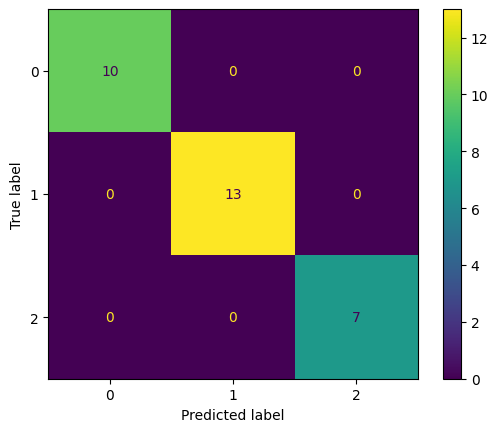

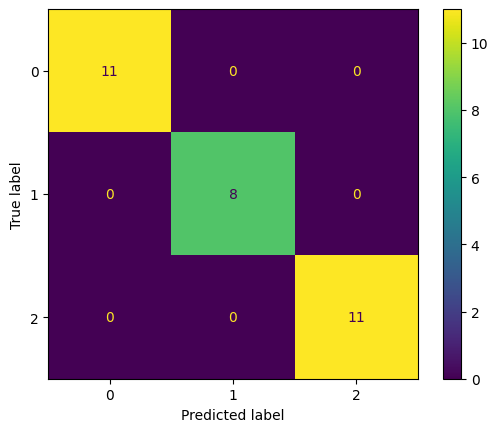

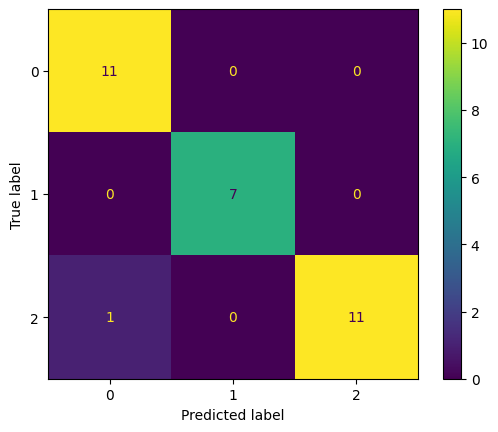

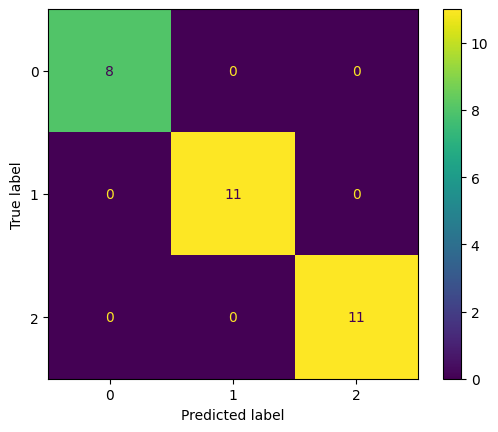

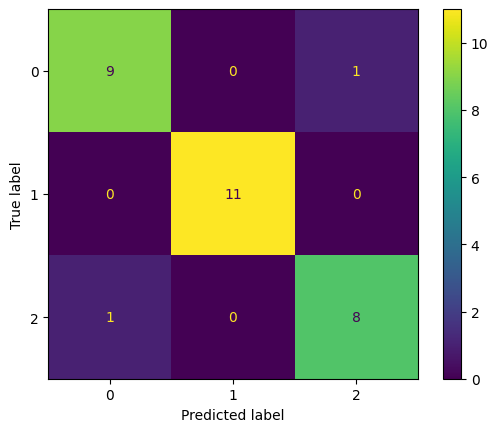

In [28]:
# for i in range(len(dataset[0])-1):
# 	str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)
# normalize input variables
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)
# evaluate algorithm
n_folds = 5
l_rate = 0.1 # ลด
n_epoch = 1000 # เพิ่ม
n_hidden = 10
scores = evaluate_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden)
mean_accuracy = sum(scores) / len(scores)
print(f' ==> [Line 13]: \033[38;2;168;222;231m[scores]\033[0m({type(scores).__name__}) = \033[38;2;2;222;41m{scores}\033[0m')
print(f' ==> [Line 15]: \033[38;2;185;50;113m[mean_accuracy]\033[0m({type(mean_accuracy).__name__}) = \033[38;2;190;227;4m{mean_accuracy}\033[0m')

 ==> [Line 13]: [scores](list) = [100.0, 90.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 80.0, 100.0]
 ==> [Line 15]: [mean_accuracy](float) = 98.0


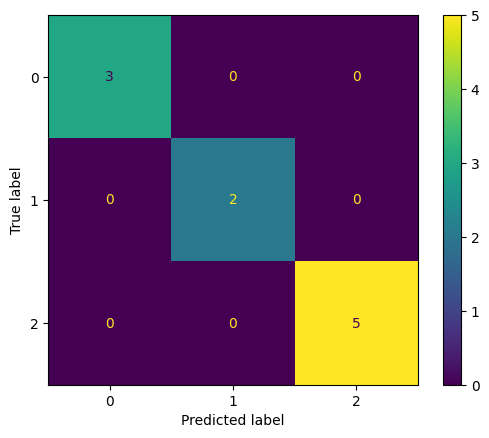

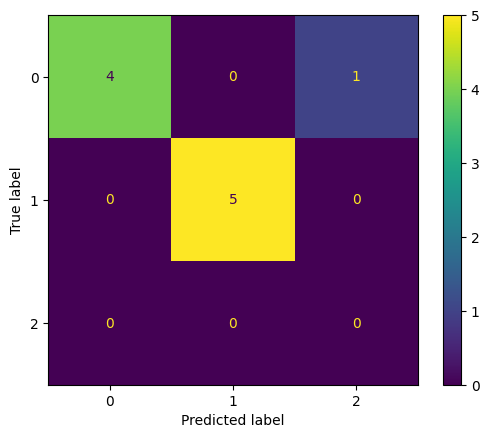

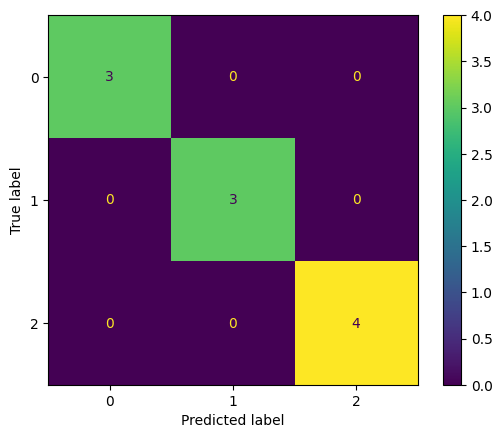

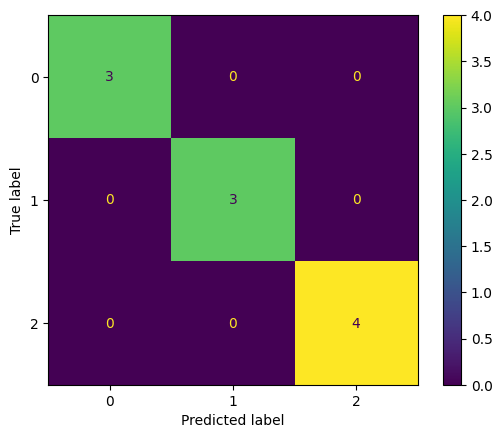

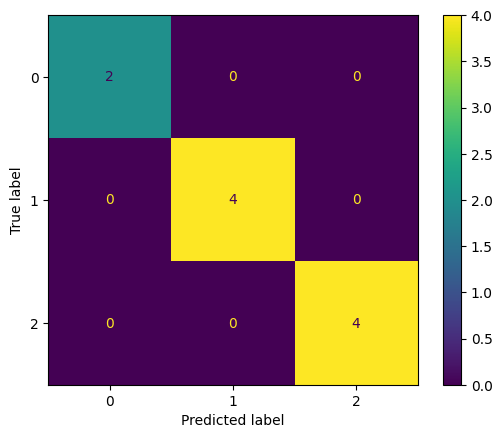

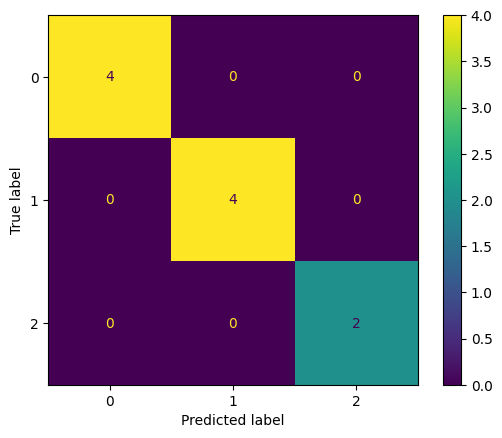

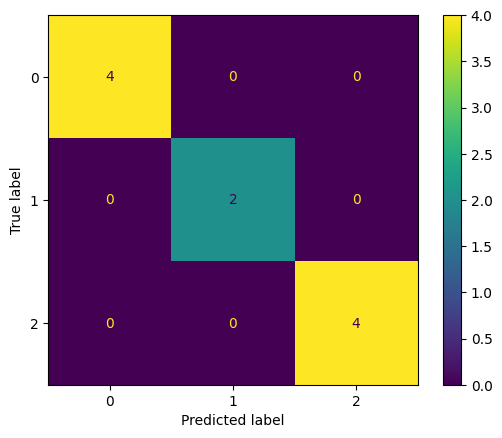

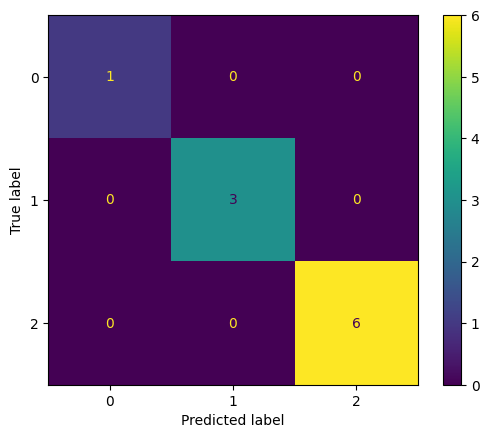

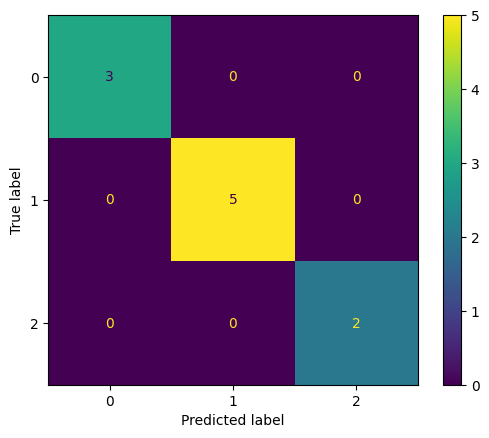

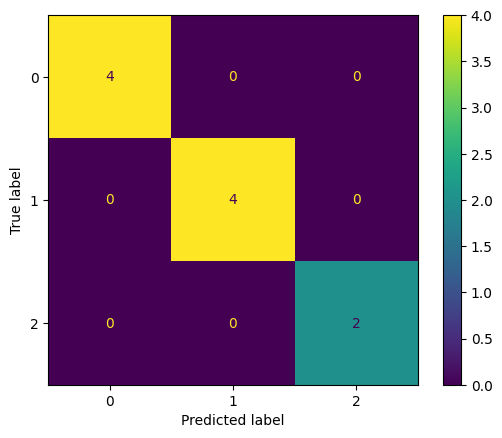

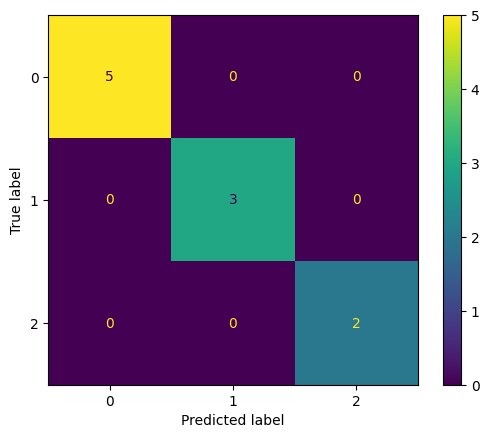

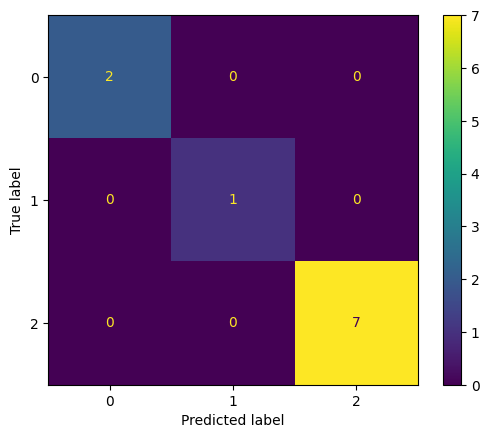

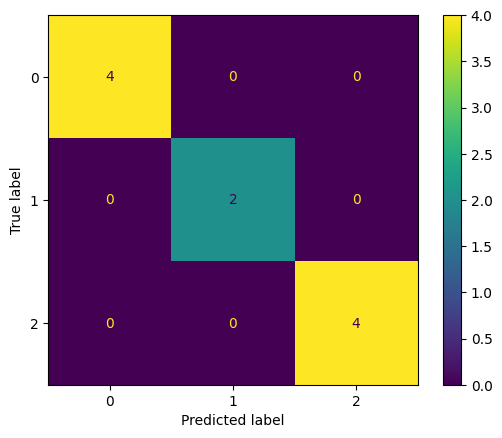

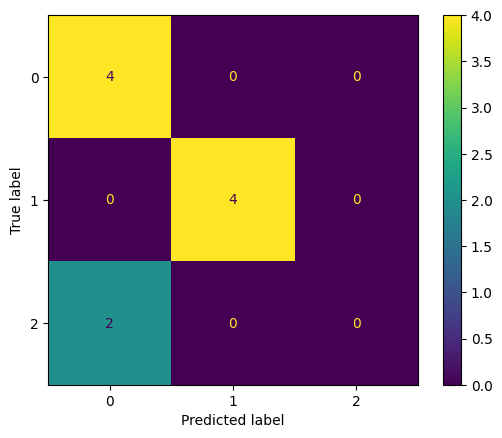

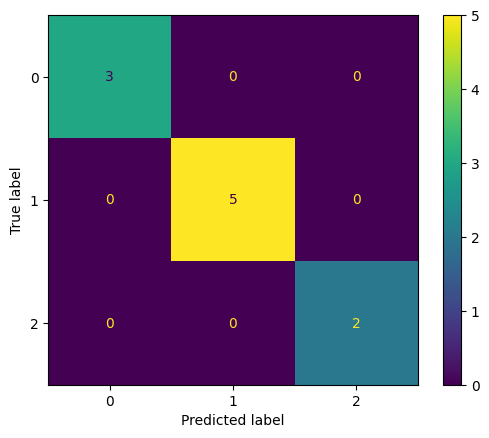

In [73]:
# for i in range(len(dataset[0])-1):
# 	str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)
# normalize input variables
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)
# evaluate algorithm
n_folds = 15
l_rate = 0.1 # ลด
n_epoch = 500 # เพิ่ม
n_hidden = 10
scores = evaluate_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden)
mean_accuracy = sum(scores) / len(scores)
print(f' ==> [Line 13]: \033[38;2;168;222;231m[scores]\033[0m({type(scores).__name__}) = \033[38;2;2;222;41m{scores}\033[0m')
print(f' ==> [Line 15]: \033[38;2;185;50;113m[mean_accuracy]\033[0m({type(mean_accuracy).__name__}) = \033[38;2;190;227;4m{mean_accuracy}\033[0m')